## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms


%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

In [5]:
# plt.figure(figsize=(6, 7))
# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
#     plt.title(y[i])
#     plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print 'forward', std

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().data[0]
    print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
def new_linear_layer(input_size, output_size, mean, std):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)    
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

In [8]:
# std N(0,1) init
# layers = []
# mean = 0
# std = 0.1
# layers.append(new_linear_layer(784, 500, mean, std))
# layers.append(nn.ReLU())
# for i in range(10):
#     layers.append(new_linear_layer(500, 500, mean, std))
#     layers.append(nn.ReLU())
# layers.append(new_linear_layer(500, 10, mean, std))
# layers.append(nn.LogSoftmax())
# network = nn.Sequential(*layers)
# network

# Xavier init
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean, std=np.sqrt(2.0/500)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean, std=np.sqrt(2.0/500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean, std=np.sqrt(2.0/10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): ReLU()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): ReLU()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): ReLU()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): ReLU()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): ReLU()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): ReLU()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): ReLU()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

In [31]:
##### YOUR CODE HERE #####


#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = nhttps://spheremailru.slack.com/messages/C0N9V035G/etwork(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.995824813843
forward 1.56238365173
forward 1.48805010319
backward 0.00327863940038
backward 0.000682053272612
backward 0.000604301749263


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [32]:
##### YOUR CODE HERE #####


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [61]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p
        self.evaluate=False
        
    def forward(self, X):
        if self.training:
            mask = torch.zeros(self.weight.size())+self.p
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*(1-self.p)
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(X, self.weight*mask)+self.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [56]:
# Add dropout to network
layers = []
layers.append(new_linear_layer(784, 200, mean, std=np.sqrt(2.0/500)))
layers.append(nn.ReLU())
layers.append(nn.Dropout())
layers.append(new_linear_layer(200, 200, mean, std=np.sqrt(2.0/500)))
layers.append(nn.ReLU())
layers.append(nn.Dropout())
layers.append(new_linear_layer(200, 10, mean, std=np.sqrt(2.0/500)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5)
  (3): Linear(in_features=200, out_features=200, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5)
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): LogSoftmax()
)

In [62]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys

def train(network, train_loader, test_loader, epochs, learning_rate, ravel_init=False):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            network.train()
            for X, y in train_loader:
                X = Variable(X)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                y = Variable(y)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            network.eval()
            for X, y in test_loader:
                X = Variable(X)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                y = Variable(y)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

forward 0.983475804329
forward 1.63684892654
forward 1.45862853527
backward 0.00256596528925
backward 0.000507084070705
backward 0.000464405457024
forward 0.989818990231
forward 1.56653594971
forward 1.32800447941
backward 0.00243662809953
backward 0.000475377833936
backward 0.000421212491347
forward 0.986388385296
forward 1.47173929214
forward 1.19932758808
backward 0.00244885100983
backward 0.000464560289402
backward 0.000407488463679
forward 0.984797120094
forward 1.43326437473
forward 1.14315807819
backward 0.00231496221386
backward 0.000427825987572
backward 0.000359268015018
forward 1.01405239105
forward 1.46724772453
forward 1.16334450245
backward 0.00226512458175
backward 0.000412073510233
backward 0.000347001681803
forward 0.998208999634
forward 1.43063557148
forward 1.12161195278
backward 0.0023270517122
backward 0.000416691007558
backward 0.000350763351889
forward 0.990998566151
forward 1.40347075462
forward 1.07925736904
backward 0.00224270508625
backward 0.000402583304094


backward 0.00148796348367
backward 0.000266564486083
backward 0.0002507227764
forward 1.00337159634
forward 1.72847163677
forward 1.72001445293
backward 0.00157046981622
backward 0.000270065356744
backward 0.000254159647739
forward 1.01787376404
forward 1.69728517532
forward 1.68676638603
backward 0.00128870550543
backward 0.000231486119446
backward 0.000217173466808
forward 0.988202750683
forward 1.64971876144
forward 1.67939603329
backward 0.00155375653412
backward 0.000274223421002
backward 0.000259685504716
forward 1.00323784351
forward 1.68834853172
forward 1.70484662056
backward 0.00135942944326
backward 0.000242413967499
backward 0.000232114703977
forward 1.00398945808
forward 1.7095811367
forward 1.78517711163
backward 0.00130163703579
backward 0.000238072112552
backward 0.000223715629545
forward 1.01510000229
forward 1.7836856842
forward 1.82752382755
backward 0.00137249170803
backward 0.000241201676545
backward 0.000245611125138
forward 1.02041149139
forward 1.70872414112
for

backward 0.000270648684818
backward 0.000288268260192
forward 1.02548110485
forward 1.68802583218
forward 1.8423589468
backward 0.00117796985433
backward 0.000211729144212
backward 0.000213974853978
forward 1.00125002861
forward 1.66492080688
forward 1.82026565075
backward 0.00116761703975
backward 0.000208042911254
backward 0.000215686581214
forward 1.02804863453
forward 1.70326077938
forward 1.881508708
backward 0.00114209193271
backward 0.000209684745641
backward 0.000212852755794
forward 0.993716239929
forward 1.63250505924
forward 1.77201402187
backward 0.00126090098638
backward 0.000231702448218
backward 0.000238332097069
forward 0.998463213444
forward 1.64640414715
forward 1.82966387272
backward 0.00107802415732
backward 0.000197290966753
backward 0.000207675329875
forward 0.985967278481
forward 1.63771486282
forward 1.81614339352
backward 0.00102986884303
backward 0.000192501611309
backward 0.000211582155316
forward 1.00909554958
forward 1.69693732262
forward 1.89067101479
back

forward 1.0393229723
forward 1.58292078972
forward 1.83915233612
backward 0.00108207762241
backward 0.000194428750547
backward 0.000183561613085
forward 1.0055077076
forward 1.57541024685
forward 1.8448895216
backward 0.00114456727169
backward 0.000216322223423
backward 0.000218881104956
forward 0.984018862247
forward 1.54428935051
forward 1.7984803915
backward 0.00104169524275
backward 0.000201996837859
backward 0.000211632272112
forward 0.995642900467
forward 1.56955468655
forward 1.84152555466
backward 0.00109503802378
backward 0.000213372317376
backward 0.000217031949433
forward 1.0115762949
forward 1.60340154171
forward 1.81684803963
backward 0.00108889257535
backward 0.000210580285056
backward 0.000226426956942
forward 1.00709569454
forward 1.57563722134
forward 1.82440960407
backward 0.00124475720804
backward 0.000240613560891
backward 0.000245497154538
forward 1.02553582191
forward 1.69604611397
forward 2.00569176674
backward 0.00111321732402
backward 0.000209867270314
backward

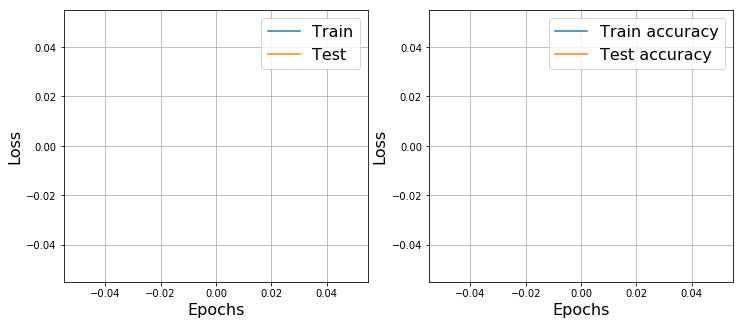

In [58]:
train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

In [65]:
# Add dropconnect to network
layers = []
layers.append(DropConnect(784, 200))
layers.append(nn.ReLU())
layers.append(DropConnect(200, 200))
layers.append(nn.ReLU())
layers.append(DropConnect(200, 10))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): DropConnect(
  )
  (1): ReLU()
  (2): DropConnect(
  )
  (3): ReLU()
  (4): DropConnect(
  )
  (5): LogSoftmax()
)

Epoch 3... (Train/Test) NLL: 0.067/0.060	Accuracy: 0.979/0.982

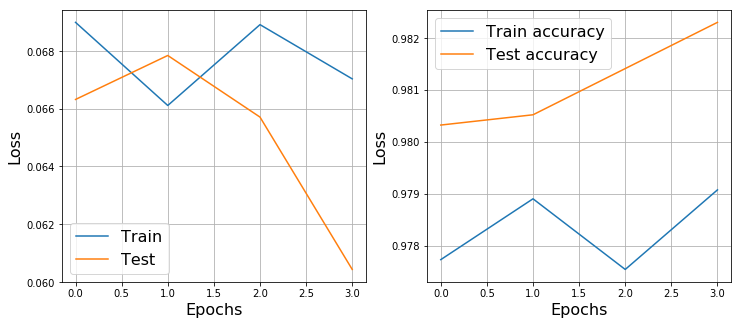

In [69]:
train(network, train_loader, test_loader, 4, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по третьей части </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [137]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = ##### YOUR CODE HERE #####
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [ ]:
##### YOUR CODE HERE #####

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: